In [25]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import svm
import time
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings("ignore")

### Get Data

In [3]:
df_train = pd.read_csv("Kannada-MNIST/train.csv")
df_val = pd.read_csv('Kannada-MNIST/Dig-MNIST.csv')

print(f"train.csv size is {df_train.shape}")
print(f"val_data size is {df_val.shape}")

train.csv size is (60000, 785)
val_data size is (10240, 785)


### Show Data

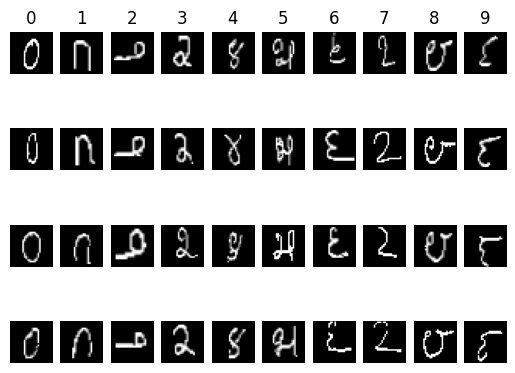

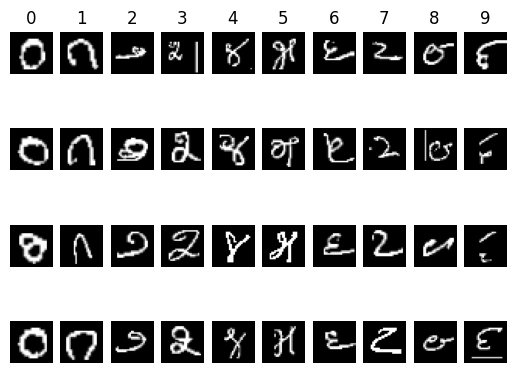

In [5]:
def show_imgs(x_train, y_train, rows=3):
    classes = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
    for y, cls in enumerate(classes):
        idxs = np.nonzero([i == y for i in y_train])
        idxs = np.random.choice(idxs[0], rows)
        for i , idx in enumerate(idxs):
            plt_idx = i * len(classes) + y + 1
            plt.subplot(rows, len(classes), plt_idx)
            plt.imshow(x_train.iloc[idx].values.reshape((28,28)), cmap='gray')
            plt.axis("off")
            if i == 0:
                plt.title(cls)
    plt.show()

# train.csv
show_imgs(df_train.iloc[:,1:], df_train.iloc[:,0], rows=4)

# Dig-MNIST.csv
show_imgs(df_val.iloc[:,1:], df_val.iloc[:,0], rows=4)


### Use PCA

In [6]:
x = df_train.iloc[:,1:]
y = df_train.iloc[:,0]

Text(0.5, 1.0, 'Visualizing Kannada MNIST through PCA')

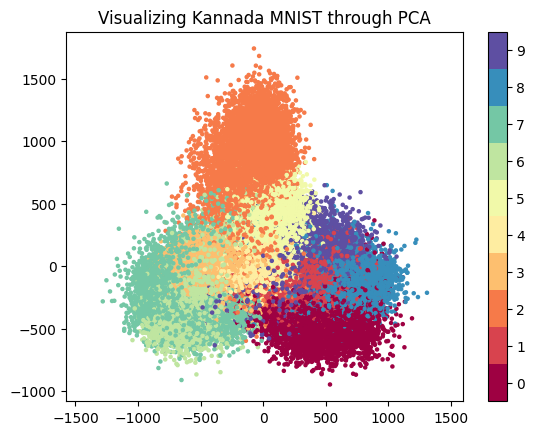

In [10]:
pca = PCA(n_components=2) # project from 784 to 2 dimensions
principalComponents = pca.fit_transform(x)

plt.scatter(principalComponents[:, 0], principalComponents[:, 1], s=5, c=y, cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('Visualizing Kannada MNIST through PCA')


### Split Dataset

In [32]:
def one_hot(labels,Label_class):
    one_hot_label = np.array([[int(i == int(labels[j])) for i in range(Label_class)] for j in range(len(labels))])
    return one_hot_label
    
def data_prep(raw):
    # transform label to one-hot
    out_y = one_hot(raw.label, num_classes)
    # reshape pixels to image
    num_images = raw.shape[0]
    x_as_array = raw.values[:,1:]
    x_shaped_array = x_as_array.reshape(num_images, img_rows, img_cols, 1)
    # normalization
    out_x = x_shaped_array / 255
    return out_x, out_y

img_rows, img_cols = 28, 28
num_classes = 10

x_train, y_train = data_prep(df_train)
x_val, y_val = data_prep(df_val)

x_train, x_test, y_train, y_test = train_test_split(np.concatenate((x_train, x_val)), 
                                                        np.concatenate((y_train, y_val)),
                                                        test_size=0.2, shuffle=True,
                                                        random_state=42, stratify=np.concatenate((y_train, y_val)))
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test,
                                                test_size=0.5, shuffle=True,
                                                random_state=42, stratify=y_test)

print(f"Training data size is {x_train.shape}")
print(f"Training data size is {y_train.shape}")
print(f"Validation data size is {x_val.shape}")
print(f"Validation data size is {y_val.shape}")
print(f"Testing data size is {x_test.shape}")
print(f"Testing data size is {y_test.shape}")


Training data size is (56192, 28, 28, 1)
Training data size is (56192, 10)
Validation data size is (7024, 28, 28, 1)
Validation data size is (7024, 10)
Testing data size is (7024, 28, 28, 1)
Testing data size is (7024, 10)


### SVM

#### Dimension Reduce

In [33]:
svm_x_train = x_train.reshape(x_train.shape[0],-1)
svm_x_test = x_test.reshape(x_test.shape[0],-1)

In [34]:
pca = PCA(n_components=0.7,whiten=True)
x_train_PCA = pca.fit_transform(svm_x_train)
x_test_PCA = pca.transform(svm_x_test)

### Train

In [36]:
svc_model = svm.SVC(kernel='rbf',C=10, gamma='auto')
_ = svc_model.fit(x_train_PCA, y_train.argmax(axis=1))

y_pred_sv = svc_model.predict(x_test_PCA)
sv_acc = accuracy_score(y_pred_sv, y_test.argmax(axis=1))
print('accuracy is', sv_acc)

accuracy is 0.9790717539863326


In [37]:
print(classification_report(y_test.argmax(axis=1), y_pred_sv))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       702
           1       0.97      0.98      0.98       702
           2       0.99      0.98      0.99       703
           3       0.98      0.97      0.98       702
           4       0.99      0.99      0.99       703
           5       0.99      0.99      0.99       703
           6       0.95      0.96      0.96       703
           7       0.96      0.97      0.97       702
           8       0.99      0.99      0.99       702
           9       0.99      0.98      0.99       702

    accuracy                           0.98      7024
   macro avg       0.98      0.98      0.98      7024
weighted avg       0.98      0.98      0.98      7024



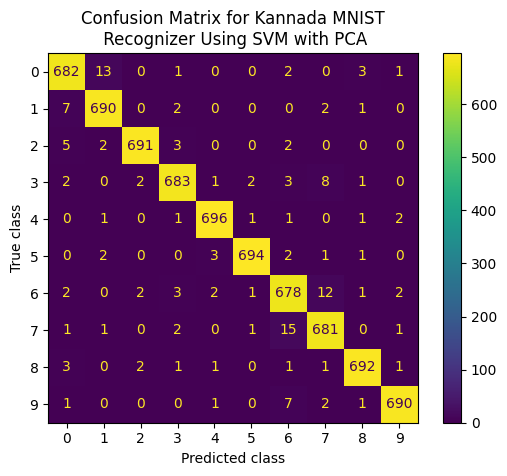

In [38]:
matrix_svm = confusion_matrix(y_test.argmax(axis=1), y_pred_sv)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix_svm, display_labels=np.unique(y))
disp.plot()
plt.title('Confusion Matrix for Kannada MNIST\n Recognizer Using SVM with PCA')
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.show()

### GridSearch

In [39]:
from sklearn.model_selection import GridSearchCV
 
param_grid = {
  'C': [0.1, 1, 10],
  'gamma': ['scale', 'auto'],
  'kernel': ['linear', 'rbf']  
}
 
grid_search = GridSearchCV(svm.SVC(), param_grid, cv=5)  
 
grid_search.fit(x_train_PCA, y_train.argmax(axis=1))
 
print("Best parameters:", grid_search.best_params_)
 
best_model = grid_search.best_estimator_
 
y_pred_best = best_model.predict(x_test_PCA)
 
print("Accuracy after optimize:", accuracy_score(y_test.argmax(axis=1), y_pred_best))

Best parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Accuracy after optimize: 0.9790717539863326
